<a href="https://colab.research.google.com/github/Taewan0508/multi_indicator_strategy/blob/main/multi_indicator_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-4068349167.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(all_symbols, start = start, end = end, progress = False)


Signals sample:


Ticker,AAPL,NVDA,MSFT,TSLA
Date,,,,
2025-11-25,1,-1,-1,-1
2025-11-26,1,-1,-1,-1
2025-11-28,1,-1,-1,-1
2025-12-01,1,-1,-1,-1
2025-12-02,1,-1,-1,-1
2025-12-03,1,-1,-1,1
2025-12-04,1,-1,-1,-1
2025-12-05,1,-1,-1,1
2025-12-08,1,-1,-1,1



Strategy stats:
CAGR: 0.1759
AnnVol: 0.4055
Sharpe: 0.6023
MaxDrawdown: -0.6483
TotalReturn: 12.1725

Benchmark stats:
CAGR: 0.3922
AnnVol: 0.2987
Sharpe: 1.2580
MaxDrawdown: -0.4836
TotalReturn: 192.2380

Number of trades (approx): 1499
Win rate (days with +net pnl / trading days): 0.500


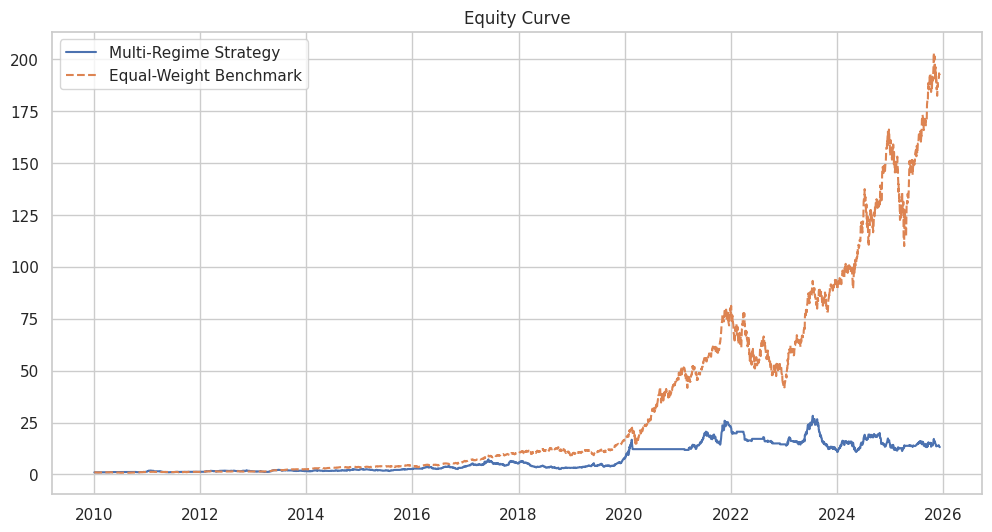

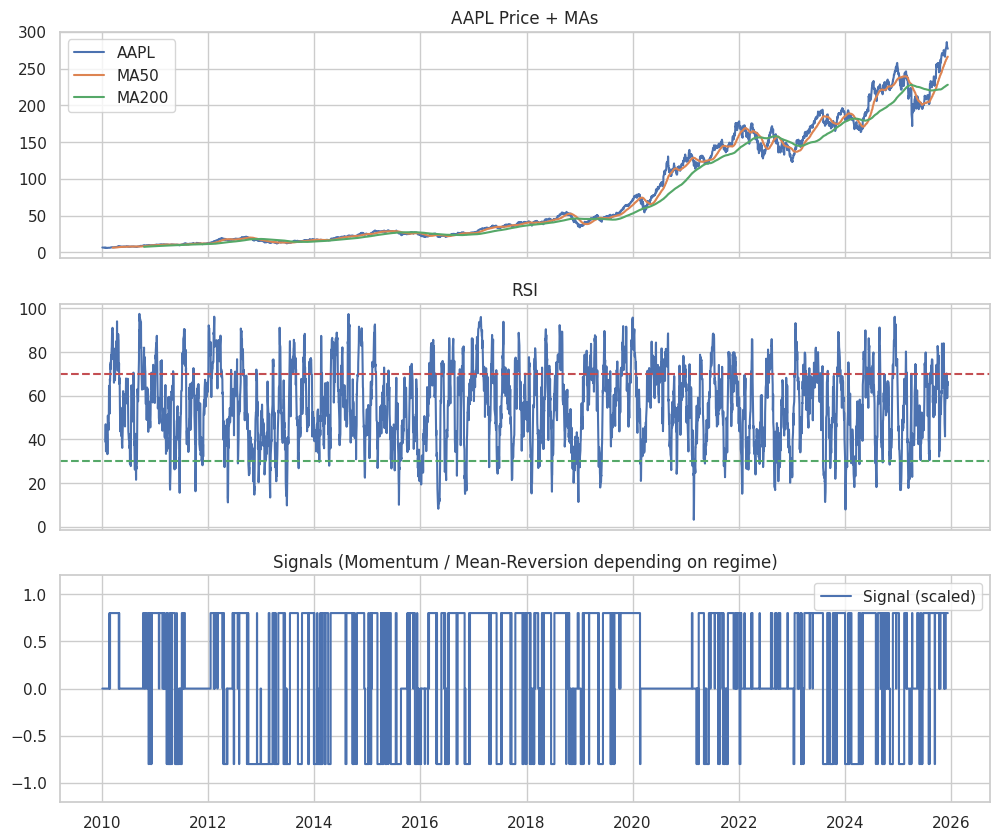

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

tickers = ["AAPL", "NVDA", "MSFT", "TSLA"]
start = "2010-01-01"
end = datetime.today().strftime("%Y-%m-%d")

vix_symbol = "^VIX"
target_vol = 0.20         ## annual target vol for position sizing (20%)
vol_lookback = 63         ## lookback for realized vol in days (quarter ~63)
ma_short = 50             ## for trend detection
ma_long = 200
rsi_length = 14           ## RSI period
momentum_lookback = 20    ## days for momentum (20-days)
vix_threshold = 20.0      ## VIX threshold to consider "low volatility"
trade_cost = 0.0005       ## proportional round-trip cost (0.05%)
slippage = 0.0005         ## slippage per trade (0.05%)

## Download data
all_symbols = tickers + [vix_symbol]
raw = yf.download(all_symbols, start = start, end = end, progress = False)
raw = raw["Close"].copy().dropna(how='all')

## seperate
prices = raw[tickers].dropna(how='all')
vix = raw[vix_symbol].dropna()

## align indices
prices = prices.loc[prices.index.intersection(vix.index)]
vix = vix.loc[prices.index]

## Features: RETURNS, VOL, MA, RSI, MOMENTUM
returns = prices.pct_change().fillna(0)

## realized vol per asset (rolling)
realized_vol = returns.rolling(vol_lookback).std() * np.sqrt(252)

## moving averages for trend detection
ma_s = prices.rolling(ma_short).mean()
ma_l = prices.rolling(ma_long).mean()
ma_slope = (ma_s - ma_l) / ma_l ## simple slope proxy

## RSI function
def compute_RSI(series, length= 14):
  delta = series.diff()
  gain = delta.clip(lower = 0)
  loss = -delta.clip(upper = 0)
  avg_gain = gain.rolling(length).mean()
  avg_loss = loss.rolling(length).mean()
  rs = avg_gain / avg_loss
  rsi = 100 - (100 / (1+ rs))
  return rsi

rsi = prices.apply(lambda col: compute_RSI(col, rsi_length))

## momentum: n-day return
momentum = prices.pct_change(periods = momentum_lookback)

## REGIME FILTERS AND SIGNALS
threshold_trend = 0.02

signals = pd.DataFrame(0, index=prices.index, columns=prices.columns)

for t in tickers:
  sig = pd.Series(0, index=prices.index)
  vix_low = vix < vix_threshold
  trend_weak = ma_slope[t].abs() < threshold_trend

  ## Momentum rule (only when VIX low)
  ## simple momentum: go long if n-day return > 0, short if < 0
  mom_sig = momentum[t].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

  ## Mean-reversion rule (only when trend weak): RSI-Based
  rsi_long = rsi[t] < 30 ## RSi oversold -> long
  rsi_short = rsi[t] > 70 ## RSI overbought -> short
  mr_sig = pd.Series(0, index=prices.index)
  mr_sig[rsi_long] = 1
  mr_sig[rsi_short] = -1

## Compose final signal per day
## Priority: if vix_low -> momentum; elif trend_weak -> meanReversion; else 0
  sig[vix_low] = mom_sig[vix_low]
  sig[~vix_low & trend_weak] = mr_sig[~vix_low & trend_weak]
## Else remains 0

  signals[t] = sig

## align and print sample
print("Signals sample:")
display(signals.tail(10))

## POSITION SIZING (Vol target)
## compute weight(leverage) for each asset so its annaualized vol ~ target_vol
## weight = target_vol / realized_vol ; cap weights to aviod huge leverages
max_leverage = 2.0

weights = target_vol / realized_vol
weights = weights.clip(upper=max_leverage).fillna(0)

## final position(signed) = signal * weight (we'll apply shift(1) for realistic execution)
position = signals.shift(1) * weights

## BACKTEST: Daily pnl with costs

# Use last close to next-day entry assumption -> shift signals to avoid look-ahead
pos = position.shift(1).fillna(0)
# daily strategy return = pos * returns (elementwise)
raw_pnl = (pos * returns).sum(axis=1)  # sum across assets (portfolio)
# transaction costs: when position changes, incur cost on turnover
turnover = (pos - pos.shift(1)).abs().sum(axis=1)  # sum absolute change across assets
costs = turnover * trade_cost
slip = turnover * slippage
strategy_net = raw_pnl - costs - slip

# compute buy & hold benchmark (equal-weighted)
bw = (1/len(tickers)) * returns.sum(axis=1)  # naive benchmark daily returns

## METRICS

def performance_stats(daily_returns, periods=252):
    dr = daily_returns.dropna()
    cum_return = (1+dr).prod() - 1
    n = len(dr)
    cagr = (1 + cum_return) ** (periods / n) - 1 if n>0 else np.nan
    ann_vol = dr.std() * np.sqrt(periods)
    sharpe = (dr.mean() * periods) / (dr.std() * np.sqrt(periods)) if dr.std() != 0 else np.nan
    # MDD
    eq = (1+dr).cumprod()
    peak = eq.cummax()
    drawdown = (eq - peak) / peak
    mdd = drawdown.min()
    return {"CAGR": cagr, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDrawdown": mdd, "TotalReturn": cum_return}

strat_stats = performance_stats(strategy_net)
bench_stats = performance_stats(bw)

print("\nStrategy stats:")
for k,v in strat_stats.items():
    print(f"{k}: {v:.4f}")
print("\nBenchmark stats:")
for k,v in bench_stats.items():
    print(f"{k}: {v:.4f}")

# trade stats
trade_entries = (signals.shift(1) != 0) & (signals.shift(1) != signals.shift(2))
num_trades = trade_entries.sum().sum()
win_rate = ((strategy_net > 0).sum() / (strategy_net != 0).sum()) if (strategy_net != 0).sum()>0 else np.nan
print(f"\nNumber of trades (approx): {int(num_trades)}")
print(f"Win rate (days with +net pnl / trading days): {win_rate:.3f}")

## PLOTS

# Equity curves
eq_strat = (1 + strategy_net).cumprod()
eq_bench = (1 + bw).cumprod()

plt.figure()
plt.plot(eq_strat, label="Multi-Regime Strategy")
plt.plot(eq_bench, label="Equal-Weight Benchmark", linestyle="--")
plt.title("Equity Curve")
plt.legend()
plt.show()

# sample one asset price + signals + RSI to visualize
t = tickers[0]
fig, ax = plt.subplots(3,1, figsize=(12,10), sharex=True)
ax[0].plot(prices[t], label=t)
ax[0].plot(ma_s[t], label=f"MA{ma_short}")
ax[0].plot(ma_l[t], label=f"MA{ma_long}")
ax[0].set_title(f"{t} Price + MAs")
ax[0].legend()

ax[1].plot(rsi[t], label="RSI")
ax[1].axhline(70, color='r', linestyle='--')
ax[1].axhline(30, color='g', linestyle='--')
ax[1].set_title("RSI")

ax[2].plot(signals[t].replace({-1:-0.8,0:0,1:0.8}), label="Signal (scaled)", drawstyle='steps-post')
ax[2].set_title("Signals (Momentum / Mean-Reversion depending on regime)")
ax[2].set_ylim(-1.2,1.2)
ax[2].legend()
plt.show()